# Room Classification using Graph Neural Networks

### Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
    <ul>
        <li><a href="#Imports">Imports</a></li>
        <li><a href="#func">Functions used</a></li>
    </ul>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#model">GNN Model</a></li>
    <ul>
        <li><a href="#dataLoader">Data Loader</a></li>
        <li><a href="#archi">Architecture</a></li>
        <li><a href="#train">Training</a></li> 
        <li><a href="#eval">Evaluation</a></li>
    </ul>
</ul>

<a id='intro'></a>
## Introduction

> This notebook is used to classify the room type of a node in a graph.

<a id='Imports'></a>
### Imports

In [4]:
# Only for kaggle
# !pip install torch_geometric

In [5]:
# Not included packages in kaggle

# Install torch_geometric
# !pip install /kaggle/input/torch-geometric/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl -q
# !pip install /kaggle/input/torch-geometric/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl -q

# # # library for getting distinct colores
# !pip install distinctipy -q

In [6]:
# for data wrangling
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import distinctipy
import random
from torch_geometric.utils import from_networkx

# to show advance in for loops
from tqdm import tqdm

# Using pytorch geometric
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset
import torch_geometric.transforms as T


# For the GNN model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool


# for my pc [linux]
# url = '/media/mo/DATA/Grad/Planify_Dataset/Graph/Planify_Graphs.pkl'

# for my pc [windows]
url = "D:\Grad\Planify_Dataset\Graph\Planify_Graphs.pkl"

# for kaggle
# url = '/kaggle/input/planify-graphs/Planify_Graphs.pkl'

<a id='func'></a>
### Functions used

In [7]:
geoms_columns = ['inner', 'living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'wall-in',
                    'outer_wall', 'front', 'inner_wall', 'interior',
                   'front_door', 'outer_wall', 'entrance']

N = len(geoms_columns)
colors = (np.array(distinctipy.get_colors(N)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(geoms_columns)}

In [8]:
def draw_graph(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}
    
    scales = [G.nodes[node]['roomSize'] * 10000 for node in G] 
    colormap = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]
    
    nx.draw(G, pos=pos, node_size=scales, node_color=colormap, with_labels=True, font_size=12)
    
    # Drawing the graph inside a good boundary.
    x_coords  = [pos[node][0] for node in pos]
    y_coords  = [pos[node][1] for node in pos]
    threshold = max(scales) / 100
    
    plt.xlim(min(x_coords) - threshold, max(x_coords) + threshold)
    plt.ylim(min(y_coords) - threshold, max(y_coords) + threshold)


def collate_fn(graphs_list):
    batch = Batch.from_data_list([Data.from_(g) for g in graphs_list])
    return batch

<a id='wrangling'></a>
## Data wrangling


Graph with 7 nodes and 9 edges


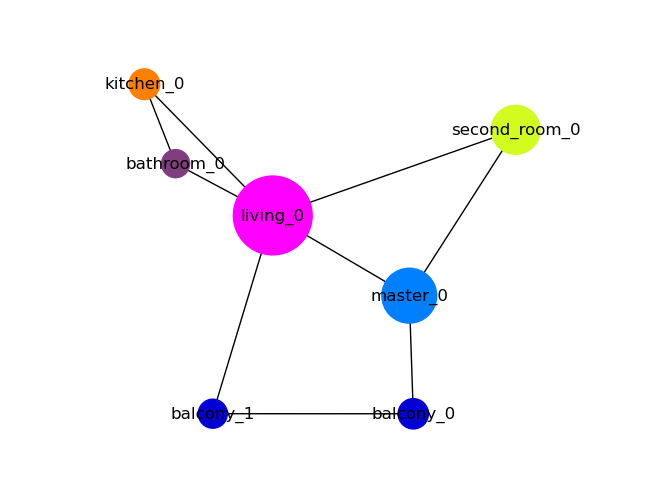

In [9]:
with open(url, 'rb') as f:
    Graphs = pickle.load(f)
    
G = Graphs[1911]
print(G)
draw_graph(G)

In [10]:
features = ['actualCentroid_x', 'actualCentroid_y', 'rec_w', 'rec_h', 'roomSize']

In [11]:
# Converting networkx graphs to pytorchGeo graphs
Graphs_pyTorch = []
for G in tqdm(Graphs):
    G_new = from_networkx(G, group_node_attrs=features, group_edge_attrs=['dist'])
    # Normalizing feature matrix (x)
    G_new = T.NormalizeFeatures()(G_new)
    
    Graphs_pyTorch.append(G_new)

Graphs_pyTorch[0]

100%|█████████████████████████████████████| 80788/80788 [00:46<00:00, 1719.82it/s]


Data(edge_index=[2, 12], roomType_name=[5], roomType_embd=[5], x=[5, 5], edge_attr=[12, 1])

> There are many types of `rooms` but we will give them a defualt number = 1.
> So, also we will decrease the embedings to be between 0:6

In [12]:
print(f'Befor: G_1 embedings are: {Graphs_pyTorch[1].roomType_embd}')
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    for j ,value in enumerate(G.roomType_embd):
        if value in [1, 4, 5, 6, 7, 8]:
            G.roomType_embd[j] = 1
        
        # making all labels from 0 to 6 only to help one_hotting
        elif value == 9:
            G.roomType_embd[j] = 4
        elif value == 10:
            G.roomType_embd[j] = 5
        elif value == 11:
            G.roomType_embd[j] = 6
print(f'After: G_1 embedings are: {Graphs_pyTorch[1].roomType_embd}')

Befor: G_1 embedings are: tensor([ 0,  1,  2,  3,  7,  7,  9, 10])


100%|█████████████████████████████████████| 80788/80788 [00:18<00:00, 4455.00it/s]

After: G_1 embedings are: tensor([0, 1, 2, 3, 1, 1, 4, 5])


> If we need to creat graphs with padding by the maximum number of nodes.

In [13]:
# # but we need to do some padding to our graphs to be all of the same number of nodes.
# padded_graphs = []
# for G in Graphs_pyTorch:
#     x          = G.x
#     y          = G.roomType_embd
#     edge_index = G.edge_index
#     edge_attr  = G.edge_attr
    
#     nu_nodes = x.shape[0]

#     padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
#     padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
#     train_mask   = torch.ones(nu_nodes)
#     train_mask   = torch.nn.functional.pad(train_mask, pad=(0, 8 - nu_nodes), mode='constant', value=0).to(bool)

#     data = Data(x = padded_x, y = padded_y, edge_index= G.edge_index, edge_attr = G.edge_attr, train_mask=train_mask)

#     padded_graphs.append(data)

# padded_graphs[0]

<a id='model'></a>
## GNN Model

<a id='dataLoader'></a>
### Data Loader

In [14]:
class Planify_Dataset(Dataset):
    def __init__(self, data):
        self.Graphs = data
    
    def __len__(self):
        return len(self.Graphs)

    def __getitem__(self, index):
        G = self.Graphs[index].clone()
        # shuffling nodes inside the same graph
        permutation = torch.randperm(G.num_nodes)

        G.x = G.x[permutation]
        G.edge_index = permutation[G.edge_index]
        G.roomType_embd = G.roomType_embd[permutation]
        # padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
        # padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
                
        return G

In [25]:
# There is a problem here, the first graph has this problem on my device [windows]

batch_size = 128
dataset = Planify_Dataset(Graphs_pyTorch[1:])
loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)

<a id='archi'></a>
### Architecture

In [61]:
class GCN(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, nu_classes):
        super().__init__()
        self.gc1 = GATConv(input_channels, hidden_channels, heads=8)
        self.gc2 = GATConv(hidden_channels * 8, hidden_channels * 8, heads=8)
        self.gc3 = GATConv(hidden_channels * 8 * 8, hidden_channels * 8, heads=8)
        
        self.fc1 = nn.Linear(hidden_channels * 8 * 8, nu_classes * 8)
        self.fc2 = nn.Linear(nu_classes * 8, nu_classes)
        
        self.Classifier = nn.Linear(nu_classes, nu_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.gc1(x, edge_index)
        x = x.relu()
        # x = F.dropout(x, training=self.training)

        x = self.gc2(x, edge_index)
        x = x.relu()
        # x = F.dropout(x, training=self.training)
        
        x = self.gc3(x, edge_index)
        x = x.relu()
        
        x = self.fc1(x)
        x = x.relu()
        
        x = self.fc2(x)
        x = x.relu()
        
        x = self.Classifier(x)
        x = self.Classifier(x)
        
        return x.relu()
    


nu_features    = Graphs_pyTorch[0].x.shape[0]
# number_classes = 12 # there is 12 distict classes in our dataset
number_classes = 7 # if we consider all rooms has the same label = 1


model = GCN(nu_features, hidden_channels=16, nu_classes=number_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# to monitor the loss & accuracy.
errors = []
acc = []
model

GCN(
  (gc1): GATConv(5, 16, heads=8)
  (gc2): GATConv(128, 128, heads=8)
  (gc3): GATConv(1024, 128, heads=8)
  (fc1): Linear(in_features=1024, out_features=56, bias=True)
  (fc2): Linear(in_features=56, out_features=7, bias=True)
  (Classifier): Linear(in_features=7, out_features=7, bias=True)
)

In [62]:
# Hyperparameters
learning_rate = 0.001
nu_epochs = 100

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.972)

# def scheduler(epoch, lr)
#     if epoch < 20:
#         return lr
#     else:
#         return lr * 0.99

<a id='train'></a>
### Training


In [63]:
# Saving model function
import os

# checkpoint_dir = '/kaggle/working/checkpoints'
# checkpoint_dir = '/media/mo/DATA/Grad/Planify_Dataset/Graph/checkpoints'
checkpoint_dir = "./checkpoints"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    

def save_checkpoint(model, optimizer, epoch):
    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
    # Saving model each 15 epochs
    if epoch % 20 == 0:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch
        }, checkpoint_path)
        
        print('Model saved :)')

In [64]:
for epoch in range(nu_epochs):
    running_loss = 0.0
    train_acc    = 0.0
    for i, data in tqdm(enumerate(loader), desc='Planifying', total=len(loader)):
        optimizer.zero_grad()
        
        # Forward pass 
        logits    = model(data.to(device)).to(device)
        
        # print(logits.shape)
        # one_hot_y = F.one_hot(data.roomType_embd, num_classes=number_classes).float()
        # computing loss through crossEntropy loss function
        loss = criterion(logits, data.roomType_embd)

        # Backward pass
        loss.backward()

        # Updating parameters
        optimizer.step()
        # current_lr = optimizer.param_groups[0]['lr']
        # optimizer = torch.optim.Adam(model.parameters(), lr=scheduler(epoch, current_lr))

        # Monitoring
        running_loss += loss.item()
        train_acc += (torch.argmax(logits, 1).flatten() == data.roomType_embd).type(torch.float).mean().item()
        lr = optimizer.param_groups[0]['lr']
        
        
    print(data.roomType_embd[:10])
    print(torch.argmax(logits, 1)[:10])
        
    errors.append(running_loss/batch_size)
    acc.append(train_acc/batch_size)

    # Updating scheduler each 15 epochs.
    scheduler.step()
    
    # Saving the model.
    save_checkpoint(model, optimizer, epoch)
    
    # Monitoring and printing.
    batch_size = len(loader)
    print(f'Epoch: {epoch + 1}/{nu_epochs} | lr: {lr} | avg_loss: {running_loss/batch_size:.5f} | training_acc: {train_acc/batch_size * 100:.5f}%')

Planifying: 100%|███████████████████████████████| 632/632 [00:26<00:00, 24.26it/s]


tensor([1, 1, 4, 2, 0, 3, 4, 2, 1, 1], device='cuda:0')
tensor([1, 4, 4, 0, 1, 4, 1, 4, 1, 1], device='cuda:0')
Model saved :)
Epoch: 1/100 | lr: 0.001 | avg_loss: 1.59739 | training_acc: 39.60247%


Planifying: 100%|███████████████████████████████| 632/632 [00:26<00:00, 24.06it/s]


tensor([2, 1, 3, 4, 1, 0, 1, 4, 3, 1], device='cuda:0')
tensor([1, 1, 1, 4, 1, 0, 1, 1, 1, 1], device='cuda:0')
Epoch: 2/100 | lr: 0.001 | avg_loss: 1.23310 | training_acc: 50.41240%


Planifying: 100%|███████████████████████████████| 632/632 [00:26<00:00, 23.80it/s]


tensor([0, 3, 2, 3, 1, 4, 1, 1, 2, 1], device='cuda:0')
tensor([0, 1, 3, 1, 1, 4, 1, 1, 4, 1], device='cuda:0')
Epoch: 3/100 | lr: 0.001 | avg_loss: 1.12636 | training_acc: 55.17489%


Planifying: 100%|███████████████████████████████| 632/632 [00:26<00:00, 23.80it/s]


tensor([4, 2, 1, 0, 3, 1, 3, 1, 1, 0], device='cuda:0')
tensor([4, 1, 1, 0, 4, 1, 3, 1, 1, 0], device='cuda:0')
Epoch: 4/100 | lr: 0.001 | avg_loss: 1.06889 | training_acc: 57.66642%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.92it/s]


tensor([3, 4, 1, 0, 1, 2, 1, 0, 3, 1], device='cuda:0')
tensor([1, 4, 1, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
Epoch: 5/100 | lr: 0.001 | avg_loss: 1.01950 | training_acc: 59.90967%


Planifying: 100%|███████████████████████████████| 632/632 [00:26<00:00, 23.42it/s]


tensor([1, 0, 3, 2, 1, 4, 3, 1, 2, 3], device='cuda:0')
tensor([1, 0, 3, 1, 1, 4, 3, 1, 1, 4], device='cuda:0')
Epoch: 6/100 | lr: 0.001 | avg_loss: 0.98036 | training_acc: 61.69815%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.15it/s]


tensor([0, 1, 4, 1, 2, 3, 1, 4, 1, 2], device='cuda:0')
tensor([0, 3, 4, 1, 1, 3, 2, 4, 3, 1], device='cuda:0')
Epoch: 7/100 | lr: 0.001 | avg_loss: 0.94765 | training_acc: 63.10794%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.94it/s]


tensor([1, 3, 3, 0, 1, 1, 2, 3, 4, 0], device='cuda:0')
tensor([1, 1, 1, 0, 1, 1, 3, 3, 1, 0], device='cuda:0')
Epoch: 8/100 | lr: 0.001 | avg_loss: 0.91824 | training_acc: 64.45505%


Planifying: 100%|███████████████████████████████| 632/632 [00:28<00:00, 22.35it/s]


tensor([1, 3, 1, 0, 2, 2, 1, 3, 0, 1], device='cuda:0')
tensor([1, 1, 1, 0, 3, 3, 1, 3, 0, 1], device='cuda:0')
Epoch: 9/100 | lr: 0.001 | avg_loss: 0.89251 | training_acc: 65.48094%


Planifying: 100%|███████████████████████████████| 632/632 [00:28<00:00, 21.80it/s]


tensor([5, 0, 4, 2, 3, 1, 1, 0, 3, 1], device='cuda:0')
tensor([1, 0, 4, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')
Epoch: 10/100 | lr: 0.001 | avg_loss: 0.87209 | training_acc: 66.34194%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.71it/s]


tensor([1, 3, 2, 0, 1, 1, 0, 1, 2, 4], device='cuda:0')
tensor([1, 1, 0, 0, 1, 1, 0, 1, 4, 4], device='cuda:0')
Epoch: 11/100 | lr: 0.001 | avg_loss: 0.85575 | training_acc: 67.00509%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.93it/s]


tensor([4, 4, 4, 1, 3, 1, 2, 0, 3, 1], device='cuda:0')
tensor([4, 4, 4, 0, 1, 1, 3, 0, 3, 1], device='cuda:0')
Epoch: 12/100 | lr: 0.001 | avg_loss: 0.83881 | training_acc: 67.73577%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.76it/s]


tensor([3, 1, 2, 1, 0, 4, 0, 2, 3, 1], device='cuda:0')
tensor([3, 1, 1, 1, 0, 4, 1, 1, 2, 1], device='cuda:0')
Epoch: 13/100 | lr: 0.001 | avg_loss: 0.82337 | training_acc: 68.41641%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.90it/s]


tensor([0, 4, 1, 2, 1, 3, 1, 4, 5, 1], device='cuda:0')
tensor([0, 4, 1, 1, 1, 2, 3, 4, 1, 1], device='cuda:0')
Epoch: 14/100 | lr: 0.001 | avg_loss: 0.81251 | training_acc: 68.81351%


Planifying: 100%|███████████████████████████████| 632/632 [00:28<00:00, 22.31it/s]


tensor([0, 1, 3, 2, 1, 5, 4, 2, 1, 1], device='cuda:0')
tensor([0, 1, 3, 1, 1, 2, 4, 2, 1, 1], device='cuda:0')
Epoch: 15/100 | lr: 0.001 | avg_loss: 0.80033 | training_acc: 69.35730%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.91it/s]


tensor([2, 1, 1, 4, 3, 0, 1, 4, 3, 0], device='cuda:0')
tensor([3, 1, 0, 4, 3, 0, 1, 4, 1, 0], device='cuda:0')
Epoch: 16/100 | lr: 0.001 | avg_loss: 0.78983 | training_acc: 69.76256%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.87it/s]


tensor([3, 1, 1, 0, 4, 2, 1, 3, 4, 1], device='cuda:0')
tensor([1, 1, 1, 0, 3, 1, 1, 1, 4, 2], device='cuda:0')
Epoch: 17/100 | lr: 0.001 | avg_loss: 0.77860 | training_acc: 70.24977%


Planifying: 100%|███████████████████████████████| 632/632 [00:28<00:00, 22.18it/s]


tensor([1, 3, 1, 4, 1, 0, 2, 1, 3, 1], device='cuda:0')
tensor([1, 3, 4, 4, 1, 0, 1, 1, 3, 1], device='cuda:0')
Epoch: 18/100 | lr: 0.001 | avg_loss: 0.76772 | training_acc: 70.66808%


Planifying: 100%|███████████████████████████████| 632/632 [00:28<00:00, 22.53it/s]


tensor([1, 0, 1, 3, 4, 4, 2, 3, 4, 1], device='cuda:0')
tensor([1, 1, 1, 1, 3, 1, 3, 1, 1, 1], device='cuda:0')
Epoch: 19/100 | lr: 0.001 | avg_loss: 0.75836 | training_acc: 70.99006%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.75it/s]


tensor([0, 1, 1, 4, 2, 3, 4, 1, 1, 4], device='cuda:0')
tensor([0, 1, 1, 4, 1, 1, 4, 1, 1, 4], device='cuda:0')
Epoch: 20/100 | lr: 0.001 | avg_loss: 0.75065 | training_acc: 71.28847%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.74it/s]


tensor([2, 1, 3, 4, 0, 1, 1, 1, 0, 3], device='cuda:0')
tensor([3, 1, 1, 4, 0, 1, 4, 1, 0, 2], device='cuda:0')
Model saved :)
Epoch: 21/100 | lr: 0.000972 | avg_loss: 0.74277 | training_acc: 71.59597%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.81it/s]


tensor([3, 2, 1, 0, 4, 1, 1, 1, 3, 1], device='cuda:0')
tensor([3, 1, 1, 0, 4, 2, 1, 1, 3, 1], device='cuda:0')
Epoch: 22/100 | lr: 0.000972 | avg_loss: 0.73471 | training_acc: 71.94805%


Planifying: 100%|███████████████████████████████| 632/632 [00:28<00:00, 22.41it/s]


tensor([0, 2, 3, 4, 1, 1, 4, 1, 1, 0], device='cuda:0')
tensor([0, 2, 3, 4, 1, 1, 4, 1, 1, 0], device='cuda:0')
Epoch: 23/100 | lr: 0.000972 | avg_loss: 0.72772 | training_acc: 72.26723%


Planifying: 100%|███████████████████████████████| 632/632 [00:29<00:00, 21.79it/s]


tensor([3, 2, 3, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
tensor([3, 3, 3, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
Epoch: 24/100 | lr: 0.000972 | avg_loss: 0.71313 | training_acc: 73.04566%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.69it/s]


tensor([3, 0, 4, 1, 1, 1, 2, 4, 0, 3], device='cuda:0')
tensor([1, 0, 4, 1, 1, 1, 1, 4, 0, 3], device='cuda:0')
Epoch: 25/100 | lr: 0.000972 | avg_loss: 0.69751 | training_acc: 73.77380%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.69it/s]


tensor([2, 4, 1, 3, 1, 0, 1, 3, 4, 1], device='cuda:0')
tensor([4, 4, 1, 3, 1, 0, 1, 3, 4, 1], device='cuda:0')
Epoch: 26/100 | lr: 0.000972 | avg_loss: 0.68650 | training_acc: 74.19550%


Planifying: 100%|███████████████████████████████| 632/632 [00:28<00:00, 22.05it/s]


tensor([2, 3, 4, 4, 1, 1, 0, 0, 2, 4], device='cuda:0')
tensor([1, 3, 3, 4, 1, 1, 0, 0, 1, 4], device='cuda:0')
Epoch: 27/100 | lr: 0.000972 | avg_loss: 0.67796 | training_acc: 74.57102%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.76it/s]


tensor([2, 0, 3, 4, 1, 1, 3, 1, 3, 2], device='cuda:0')
tensor([4, 0, 3, 4, 1, 1, 3, 1, 1, 2], device='cuda:0')
Epoch: 28/100 | lr: 0.000972 | avg_loss: 0.66993 | training_acc: 74.88226%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.74it/s]


tensor([3, 1, 4, 1, 2, 0, 2, 5, 1, 1], device='cuda:0')
tensor([3, 1, 4, 1, 2, 0, 3, 2, 1, 1], device='cuda:0')
Epoch: 29/100 | lr: 0.000972 | avg_loss: 0.66278 | training_acc: 75.22154%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.72it/s]


tensor([1, 0, 2, 1, 3, 1, 4, 4, 3, 1], device='cuda:0')
tensor([1, 0, 2, 1, 3, 1, 4, 4, 3, 3], device='cuda:0')
Epoch: 30/100 | lr: 0.000972 | avg_loss: 0.65511 | training_acc: 75.46960%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.69it/s]


tensor([1, 1, 4, 1, 0, 2, 3, 0, 1, 1], device='cuda:0')
tensor([1, 1, 4, 1, 0, 2, 2, 0, 1, 1], device='cuda:0')
Epoch: 31/100 | lr: 0.000972 | avg_loss: 0.64716 | training_acc: 75.82328%


Planifying: 100%|███████████████████████████████| 632/632 [00:28<00:00, 22.11it/s]


tensor([1, 4, 1, 0, 3, 3, 1, 4, 2, 1], device='cuda:0')
tensor([1, 4, 1, 0, 1, 3, 1, 1, 1, 1], device='cuda:0')
Epoch: 32/100 | lr: 0.000972 | avg_loss: 0.63988 | training_acc: 76.01093%


Planifying: 100%|███████████████████████████████| 632/632 [00:28<00:00, 22.14it/s]


tensor([0, 2, 4, 3, 1, 1, 1, 3, 1, 2], device='cuda:0')
tensor([0, 2, 4, 1, 3, 1, 1, 1, 1, 2], device='cuda:0')
Epoch: 33/100 | lr: 0.000972 | avg_loss: 0.63264 | training_acc: 76.30925%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.63it/s]


tensor([1, 1, 3, 0, 2, 1, 4, 4, 3, 1], device='cuda:0')
tensor([1, 1, 3, 0, 2, 1, 4, 4, 3, 1], device='cuda:0')
Epoch: 34/100 | lr: 0.000972 | avg_loss: 0.62572 | training_acc: 76.59221%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.72it/s]


tensor([4, 4, 1, 2, 0, 1, 3, 2, 1, 1], device='cuda:0')
tensor([4, 4, 1, 2, 0, 1, 2, 3, 3, 1], device='cuda:0')
Epoch: 35/100 | lr: 0.000972 | avg_loss: 0.61934 | training_acc: 76.87385%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.72it/s]


tensor([4, 3, 1, 1, 4, 0, 2, 1, 0, 4], device='cuda:0')
tensor([4, 1, 1, 1, 4, 0, 2, 1, 0, 4], device='cuda:0')
Epoch: 36/100 | lr: 0.000972 | avg_loss: 0.61214 | training_acc: 77.12551%


Planifying: 100%|███████████████████████████████| 632/632 [00:28<00:00, 22.12it/s]


tensor([0, 1, 4, 1, 1, 2, 3, 3, 3, 1], device='cuda:0')
tensor([0, 1, 4, 1, 1, 4, 3, 3, 4, 1], device='cuda:0')
Epoch: 37/100 | lr: 0.000972 | avg_loss: 0.60627 | training_acc: 77.33576%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.58it/s]


tensor([4, 3, 1, 0, 2, 1, 3, 5, 3, 1], device='cuda:0')
tensor([4, 3, 1, 0, 2, 1, 3, 4, 3, 1], device='cuda:0')
Epoch: 38/100 | lr: 0.000972 | avg_loss: 0.59823 | training_acc: 77.65646%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.71it/s]


tensor([3, 0, 5, 1, 2, 3, 1, 1, 1, 3], device='cuda:0')
tensor([1, 1, 3, 1, 1, 3, 2, 1, 4, 3], device='cuda:0')
Epoch: 39/100 | lr: 0.000972 | avg_loss: 0.59345 | training_acc: 77.86453%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.75it/s]


tensor([2, 3, 1, 0, 1, 3, 1, 3, 0, 1], device='cuda:0')
tensor([3, 2, 1, 0, 1, 3, 1, 3, 0, 1], device='cuda:0')
Epoch: 40/100 | lr: 0.000972 | avg_loss: 0.58749 | training_acc: 78.05870%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.75it/s]


tensor([3, 1, 0, 1, 1, 2, 4, 2, 4, 1], device='cuda:0')
tensor([3, 1, 0, 1, 1, 4, 4, 1, 4, 1], device='cuda:0')
Model saved :)
Epoch: 41/100 | lr: 0.0009447839999999999 | avg_loss: 0.58242 | training_acc: 78.35176%


Planifying: 100%|███████████████████████████████| 632/632 [00:28<00:00, 22.09it/s]


tensor([1, 4, 2, 1, 3, 0, 1, 0, 2, 1], device='cuda:0')
tensor([1, 4, 2, 1, 2, 0, 1, 1, 3, 1], device='cuda:0')
Epoch: 42/100 | lr: 0.0009447839999999999 | avg_loss: 0.57618 | training_acc: 78.54009%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.78it/s]


tensor([1, 2, 1, 3, 0, 4, 1, 3, 1, 1], device='cuda:0')
tensor([1, 1, 1, 3, 0, 4, 1, 3, 0, 1], device='cuda:0')
Epoch: 43/100 | lr: 0.0009447839999999999 | avg_loss: 0.57019 | training_acc: 78.76294%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.71it/s]


tensor([3, 4, 4, 1, 1, 4, 0, 4, 3, 4], device='cuda:0')
tensor([3, 4, 2, 1, 1, 3, 0, 4, 3, 2], device='cuda:0')
Epoch: 44/100 | lr: 0.0009447839999999999 | avg_loss: 0.56326 | training_acc: 79.02966%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.68it/s]


tensor([1, 4, 0, 1, 4, 2, 3, 0, 4, 2], device='cuda:0')
tensor([1, 4, 0, 1, 4, 3, 2, 0, 4, 2], device='cuda:0')
Epoch: 45/100 | lr: 0.0009447839999999999 | avg_loss: 0.55985 | training_acc: 79.15222%


Planifying: 100%|███████████████████████████████| 632/632 [00:29<00:00, 21.70it/s]


tensor([0, 2, 1, 4, 3, 1, 4, 3, 2, 1], device='cuda:0')
tensor([0, 1, 1, 4, 3, 1, 3, 1, 2, 3], device='cuda:0')
Epoch: 46/100 | lr: 0.0009447839999999999 | avg_loss: 0.55616 | training_acc: 79.29363%


Planifying: 100%|███████████████████████████████| 632/632 [00:28<00:00, 22.39it/s]


tensor([2, 0, 1, 4, 3, 4, 1, 1, 1, 4], device='cuda:0')
tensor([2, 0, 1, 4, 3, 4, 2, 1, 3, 4], device='cuda:0')
Epoch: 47/100 | lr: 0.0009447839999999999 | avg_loss: 0.55049 | training_acc: 79.47503%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.77it/s]


tensor([3, 4, 1, 0, 2, 3, 1, 1, 1, 1], device='cuda:0')
tensor([3, 4, 2, 0, 2, 3, 1, 1, 1, 1], device='cuda:0')
Epoch: 48/100 | lr: 0.0009447839999999999 | avg_loss: 0.54385 | training_acc: 79.76426%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.67it/s]


tensor([3, 1, 4, 1, 1, 0, 2, 1, 1, 2], device='cuda:0')
tensor([3, 1, 4, 1, 1, 0, 2, 0, 1, 2], device='cuda:0')
Epoch: 49/100 | lr: 0.0009447839999999999 | avg_loss: 0.54127 | training_acc: 79.84156%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.74it/s]


tensor([3, 4, 1, 3, 0, 1, 2, 1, 4, 1], device='cuda:0')
tensor([3, 4, 1, 3, 0, 1, 1, 1, 4, 1], device='cuda:0')
Epoch: 50/100 | lr: 0.0009447839999999999 | avg_loss: 0.53597 | training_acc: 80.05079%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.75it/s]


tensor([1, 0, 4, 1, 3, 1, 2, 1, 4, 1], device='cuda:0')
tensor([1, 0, 4, 1, 3, 1, 1, 1, 4, 1], device='cuda:0')
Epoch: 51/100 | lr: 0.0009447839999999999 | avg_loss: 0.53337 | training_acc: 80.14965%


Planifying: 100%|███████████████████████████████| 632/632 [00:28<00:00, 22.00it/s]


tensor([1, 2, 3, 1, 1, 0, 1, 1, 4, 3], device='cuda:0')
tensor([1, 2, 3, 2, 1, 0, 1, 1, 4, 3], device='cuda:0')
Epoch: 52/100 | lr: 0.0009447839999999999 | avg_loss: 0.52819 | training_acc: 80.34716%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.73it/s]


tensor([4, 1, 4, 3, 2, 1, 0, 1, 1, 3], device='cuda:0')
tensor([4, 1, 4, 3, 2, 1, 0, 1, 1, 3], device='cuda:0')
Epoch: 53/100 | lr: 0.0009447839999999999 | avg_loss: 0.52525 | training_acc: 80.45812%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.74it/s]


tensor([1, 0, 2, 1, 4, 1, 3, 1, 1, 4], device='cuda:0')
tensor([1, 0, 1, 1, 4, 3, 2, 1, 1, 4], device='cuda:0')
Epoch: 54/100 | lr: 0.0009447839999999999 | avg_loss: 0.52179 | training_acc: 80.61886%


Planifying: 100%|███████████████████████████████| 632/632 [00:28<00:00, 22.18it/s]


tensor([0, 3, 1, 2, 1, 1, 4, 5, 2, 4], device='cuda:0')
tensor([0, 3, 1, 2, 1, 1, 4, 4, 1, 3], device='cuda:0')
Epoch: 55/100 | lr: 0.0009447839999999999 | avg_loss: 0.51919 | training_acc: 80.71925%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.79it/s]


tensor([1, 3, 4, 0, 2, 4, 1, 4, 0, 3], device='cuda:0')
tensor([1, 3, 4, 0, 3, 4, 1, 4, 0, 3], device='cuda:0')
Epoch: 56/100 | lr: 0.0009447839999999999 | avg_loss: 0.51359 | training_acc: 80.89182%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.73it/s]


tensor([1, 0, 4, 1, 2, 3, 1, 2, 4, 1], device='cuda:0')
tensor([1, 0, 4, 1, 2, 3, 1, 2, 4, 1], device='cuda:0')
Epoch: 57/100 | lr: 0.0009447839999999999 | avg_loss: 0.51195 | training_acc: 81.03259%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.76it/s]


tensor([2, 0, 1, 4, 1, 3, 1, 3, 4, 1], device='cuda:0')
tensor([3, 0, 3, 4, 1, 2, 1, 2, 4, 1], device='cuda:0')
Epoch: 58/100 | lr: 0.0009447839999999999 | avg_loss: 0.50840 | training_acc: 81.09057%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.82it/s]


tensor([4, 2, 1, 1, 0, 3, 1, 1, 2, 0], device='cuda:0')
tensor([4, 2, 1, 1, 0, 3, 1, 1, 2, 0], device='cuda:0')
Epoch: 59/100 | lr: 0.0009447839999999999 | avg_loss: 0.50434 | training_acc: 81.34344%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.90it/s]


tensor([3, 1, 4, 1, 2, 0, 2, 1, 3, 1], device='cuda:0')
tensor([3, 1, 4, 1, 3, 0, 2, 2, 3, 1], device='cuda:0')
Epoch: 60/100 | lr: 0.0009447839999999999 | avg_loss: 0.50187 | training_acc: 81.43841%


Planifying: 100%|███████████████████████████████| 632/632 [00:28<00:00, 22.44it/s]


tensor([1, 0, 4, 1, 2, 1, 3, 3, 1, 1], device='cuda:0')
tensor([1, 0, 4, 1, 2, 3, 3, 1, 1, 1], device='cuda:0')
Model saved :)
Epoch: 61/100 | lr: 0.0009183300479999999 | avg_loss: 0.49759 | training_acc: 81.58666%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.09it/s]


tensor([3, 1, 3, 1, 2, 4, 0, 1, 0, 1], device='cuda:0')
tensor([3, 1, 3, 1, 2, 4, 0, 1, 0, 1], device='cuda:0')
Epoch: 62/100 | lr: 0.0009183300479999999 | avg_loss: 0.49539 | training_acc: 81.65164%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.13it/s]


tensor([0, 3, 1, 1, 4, 2, 1, 3, 1, 4], device='cuda:0')
tensor([0, 3, 1, 1, 4, 4, 3, 3, 1, 4], device='cuda:0')
Epoch: 63/100 | lr: 0.0009183300479999999 | avg_loss: 0.49126 | training_acc: 81.87316%


Planifying: 100%|███████████████████████████████| 632/632 [00:28<00:00, 22.37it/s]


tensor([0, 1, 2, 3, 1, 1, 3, 4, 3, 0], device='cuda:0')
tensor([0, 1, 1, 3, 1, 1, 3, 3, 3, 0], device='cuda:0')
Epoch: 64/100 | lr: 0.0009183300479999999 | avg_loss: 0.49130 | training_acc: 81.81309%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.18it/s]


tensor([4, 0, 1, 2, 3, 1, 4, 4, 1, 0], device='cuda:0')
tensor([4, 0, 1, 2, 2, 1, 4, 4, 1, 0], device='cuda:0')
Epoch: 65/100 | lr: 0.0009183300479999999 | avg_loss: 0.48680 | training_acc: 81.97998%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.09it/s]


tensor([0, 1, 1, 1, 3, 2, 3, 1, 4, 2], device='cuda:0')
tensor([0, 1, 1, 1, 3, 1, 3, 1, 4, 3], device='cuda:0')
Epoch: 66/100 | lr: 0.0009183300479999999 | avg_loss: 0.48468 | training_acc: 82.12085%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.06it/s]


tensor([1, 3, 1, 0, 1, 4, 2, 0, 3, 1], device='cuda:0')
tensor([0, 3, 1, 0, 1, 4, 2, 0, 3, 1], device='cuda:0')
Epoch: 67/100 | lr: 0.0009183300479999999 | avg_loss: 0.48415 | training_acc: 82.13164%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.01it/s]


tensor([1, 1, 0, 4, 1, 3, 2, 1, 1, 4], device='cuda:0')
tensor([2, 1, 0, 4, 1, 3, 1, 1, 1, 3], device='cuda:0')
Epoch: 68/100 | lr: 0.0009183300479999999 | avg_loss: 0.47966 | training_acc: 82.33016%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.17it/s]


tensor([4, 0, 4, 3, 2, 1, 1, 3, 1, 0], device='cuda:0')
tensor([3, 0, 4, 3, 2, 1, 1, 3, 1, 0], device='cuda:0')
Epoch: 69/100 | lr: 0.0009183300479999999 | avg_loss: 0.47740 | training_acc: 82.36686%


Planifying: 100%|███████████████████████████████| 632/632 [00:28<00:00, 22.50it/s]


tensor([1, 2, 1, 0, 3, 3, 4, 1, 2, 4], device='cuda:0')
tensor([0, 1, 1, 1, 3, 3, 1, 1, 1, 4], device='cuda:0')
Epoch: 70/100 | lr: 0.0009183300479999999 | avg_loss: 0.47588 | training_acc: 82.46682%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.22it/s]


tensor([1, 1, 0, 3, 4, 1, 1, 2, 4, 0], device='cuda:0')
tensor([1, 1, 0, 3, 4, 1, 1, 2, 4, 0], device='cuda:0')
Epoch: 71/100 | lr: 0.0009183300479999999 | avg_loss: 0.47398 | training_acc: 82.52915%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.21it/s]


tensor([3, 1, 0, 3, 1, 1, 1, 1, 0, 1], device='cuda:0')
tensor([3, 1, 0, 3, 1, 1, 1, 1, 0, 1], device='cuda:0')
Epoch: 72/100 | lr: 0.0009183300479999999 | avg_loss: 0.47024 | training_acc: 82.71088%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.22it/s]


tensor([1, 4, 2, 0, 3, 1, 1, 3, 2, 0], device='cuda:0')
tensor([1, 4, 2, 0, 3, 1, 1, 3, 2, 0], device='cuda:0')
Epoch: 73/100 | lr: 0.0009183300479999999 | avg_loss: 0.46984 | training_acc: 82.67522%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.59it/s]


tensor([1, 1, 0, 2, 4, 4, 4, 3, 0, 4], device='cuda:0')
tensor([1, 1, 0, 3, 4, 4, 1, 1, 0, 4], device='cuda:0')
Epoch: 74/100 | lr: 0.0009183300479999999 | avg_loss: 0.46675 | training_acc: 82.79234%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.24it/s]


tensor([3, 1, 1, 2, 0, 3, 1, 4, 2, 1], device='cuda:0')
tensor([1, 1, 1, 1, 0, 3, 1, 3, 4, 1], device='cuda:0')
Epoch: 75/100 | lr: 0.0009183300479999999 | avg_loss: 0.46387 | training_acc: 82.94040%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.29it/s]


tensor([1, 3, 2, 4, 1, 4, 0, 0, 2, 1], device='cuda:0')
tensor([1, 3, 1, 4, 1, 2, 0, 0, 3, 1], device='cuda:0')
Epoch: 76/100 | lr: 0.0009183300479999999 | avg_loss: 0.46279 | training_acc: 83.02069%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.21it/s]


tensor([3, 0, 1, 3, 1, 2, 4, 1, 2, 0], device='cuda:0')
tensor([3, 0, 1, 2, 1, 3, 4, 1, 1, 0], device='cuda:0')
Epoch: 77/100 | lr: 0.0009183300479999999 | avg_loss: 0.45993 | training_acc: 83.08795%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.24it/s]


tensor([3, 1, 2, 0, 1, 4, 1, 3, 4, 1], device='cuda:0')
tensor([3, 1, 2, 0, 1, 4, 1, 3, 4, 1], device='cuda:0')
Epoch: 78/100 | lr: 0.0009183300479999999 | avg_loss: 0.45867 | training_acc: 83.13283%


Planifying: 100%|███████████████████████████████| 632/632 [00:28<00:00, 22.47it/s]


tensor([1, 2, 3, 4, 0, 1, 2, 4, 0, 1], device='cuda:0')
tensor([1, 2, 3, 4, 0, 1, 2, 1, 0, 1], device='cuda:0')
Epoch: 79/100 | lr: 0.0009183300479999999 | avg_loss: 0.45676 | training_acc: 83.19493%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.29it/s]


tensor([1, 2, 3, 1, 4, 0, 1, 3, 0, 3], device='cuda:0')
tensor([1, 1, 1, 1, 4, 0, 1, 3, 0, 2], device='cuda:0')
Epoch: 80/100 | lr: 0.0009183300479999999 | avg_loss: 0.45699 | training_acc: 83.21734%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.25it/s]


tensor([3, 1, 1, 3, 1, 0, 4, 2, 3, 3], device='cuda:0')
tensor([3, 1, 1, 3, 1, 0, 4, 2, 3, 3], device='cuda:0')
Model saved :)
Epoch: 81/100 | lr: 0.0008926168066559999 | avg_loss: 0.45296 | training_acc: 83.37391%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.28it/s]


tensor([4, 1, 0, 1, 2, 1, 3, 1, 3, 0], device='cuda:0')
tensor([4, 1, 0, 1, 2, 1, 3, 1, 3, 0], device='cuda:0')
Epoch: 82/100 | lr: 0.0008926168066559999 | avg_loss: 0.44905 | training_acc: 83.56906%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.66it/s]


tensor([2, 3, 1, 1, 0, 1, 1, 2, 3, 0], device='cuda:0')
tensor([2, 3, 1, 1, 0, 1, 1, 3, 3, 0], device='cuda:0')
Epoch: 83/100 | lr: 0.0008926168066559999 | avg_loss: 0.45002 | training_acc: 83.52604%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.26it/s]


tensor([4, 1, 1, 3, 2, 4, 0, 5, 1, 1], device='cuda:0')
tensor([2, 1, 1, 3, 1, 4, 0, 3, 1, 1], device='cuda:0')
Epoch: 84/100 | lr: 0.0008926168066559999 | avg_loss: 0.44786 | training_acc: 83.60110%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.26it/s]


tensor([1, 1, 0, 2, 3, 4, 1, 4, 1, 0], device='cuda:0')
tensor([1, 0, 0, 2, 3, 2, 1, 4, 1, 0], device='cuda:0')
Epoch: 85/100 | lr: 0.0008926168066559999 | avg_loss: 0.44636 | training_acc: 83.66761%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.24it/s]


tensor([0, 4, 1, 1, 2, 4, 3, 4, 3, 0], device='cuda:0')
tensor([0, 1, 1, 1, 1, 2, 3, 4, 3, 0], device='cuda:0')
Epoch: 86/100 | lr: 0.0008926168066559999 | avg_loss: 0.44497 | training_acc: 83.71447%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.33it/s]


tensor([0, 4, 1, 2, 1, 1, 3, 3, 4, 0], device='cuda:0')
tensor([0, 4, 1, 2, 1, 1, 3, 3, 4, 0], device='cuda:0')
Epoch: 87/100 | lr: 0.0008926168066559999 | avg_loss: 0.44261 | training_acc: 83.83234%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.20it/s]


tensor([1, 1, 1, 4, 2, 4, 3, 0, 3, 1], device='cuda:0')
tensor([1, 1, 1, 4, 3, 4, 1, 0, 2, 1], device='cuda:0')
Epoch: 88/100 | lr: 0.0008926168066559999 | avg_loss: 0.44029 | training_acc: 83.93879%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.67it/s]


tensor([3, 0, 4, 2, 1, 1, 3, 1, 5, 0], device='cuda:0')
tensor([2, 0, 4, 3, 1, 1, 1, 1, 3, 0], device='cuda:0')
Epoch: 89/100 | lr: 0.0008926168066559999 | avg_loss: 0.43912 | training_acc: 83.89791%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.32it/s]


tensor([4, 0, 1, 1, 3, 4, 2, 3, 1, 3], device='cuda:0')
tensor([4, 0, 1, 1, 3, 2, 4, 2, 3, 3], device='cuda:0')
Epoch: 90/100 | lr: 0.0008926168066559999 | avg_loss: 0.44059 | training_acc: 83.91504%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 23.33it/s]


tensor([1, 2, 0, 1, 1, 3, 1, 3, 2, 1], device='cuda:0')
tensor([1, 2, 0, 1, 1, 3, 1, 3, 1, 1], device='cuda:0')
Epoch: 91/100 | lr: 0.0008926168066559999 | avg_loss: 0.43851 | training_acc: 83.97442%


Planifying: 100%|███████████████████████████████| 632/632 [00:27<00:00, 22.73it/s]


tensor([3, 2, 0, 1, 1, 4, 1, 0, 4, 4], device='cuda:0')
tensor([3, 2, 0, 1, 1, 4, 1, 0, 4, 4], device='cuda:0')
Epoch: 92/100 | lr: 0.0008926168066559999 | avg_loss: 0.43490 | training_acc: 84.11613%


Planifying: 100%|█████████████████████████████| 632/632 [2:58:59<00:00, 16.99s/it]


tensor([0, 3, 4, 3, 2, 1, 1, 1, 1, 4], device='cuda:0')
tensor([0, 3, 4, 3, 2, 1, 1, 1, 1, 4], device='cuda:0')
Epoch: 93/100 | lr: 0.0008926168066559999 | avg_loss: 0.43402 | training_acc: 84.14147%


Planifying: 100%|███████████████████████████████| 632/632 [00:42<00:00, 14.76it/s]


tensor([2, 1, 3, 4, 0, 1, 1, 3, 1, 4], device='cuda:0')
tensor([2, 1, 3, 4, 0, 1, 1, 3, 1, 4], device='cuda:0')
Epoch: 94/100 | lr: 0.0008926168066559999 | avg_loss: 0.43326 | training_acc: 84.20471%


Planifying: 100%|███████████████████████████████| 632/632 [00:55<00:00, 11.43it/s]


tensor([2, 1, 3, 0, 3, 1, 1, 4, 4, 2], device='cuda:0')
tensor([3, 1, 3, 0, 3, 3, 1, 4, 2, 2], device='cuda:0')
Epoch: 95/100 | lr: 0.0008926168066559999 | avg_loss: 0.43208 | training_acc: 84.24030%


Planifying: 100%|███████████████████████████████| 632/632 [00:59<00:00, 10.66it/s]


tensor([1, 1, 0, 3, 4, 2, 1, 1, 3, 1], device='cuda:0')
tensor([1, 1, 0, 3, 4, 2, 1, 1, 3, 1], device='cuda:0')
Epoch: 96/100 | lr: 0.0008926168066559999 | avg_loss: 0.43095 | training_acc: 84.24446%


Planifying: 100%|███████████████████████████████| 632/632 [00:59<00:00, 10.64it/s]


tensor([4, 3, 1, 1, 0, 2, 4, 1, 1, 2], device='cuda:0')
tensor([4, 3, 1, 1, 0, 2, 4, 1, 1, 2], device='cuda:0')
Epoch: 97/100 | lr: 0.0008926168066559999 | avg_loss: 0.42858 | training_acc: 84.39312%


Planifying: 100%|███████████████████████████████| 632/632 [01:01<00:00, 10.27it/s]


tensor([1, 1, 4, 3, 1, 4, 2, 0, 1, 2], device='cuda:0')
tensor([1, 1, 3, 3, 1, 4, 2, 0, 1, 2], device='cuda:0')
Epoch: 98/100 | lr: 0.0008926168066559999 | avg_loss: 0.42827 | training_acc: 84.42208%


Planifying: 100%|███████████████████████████████| 632/632 [01:00<00:00, 10.48it/s]


tensor([5, 2, 4, 3, 1, 0, 1, 1, 6, 3], device='cuda:0')
tensor([4, 4, 2, 3, 1, 0, 1, 3, 4, 3], device='cuda:0')
Epoch: 99/100 | lr: 0.0008926168066559999 | avg_loss: 0.42562 | training_acc: 84.48496%


Planifying: 100%|███████████████████████████████| 632/632 [01:00<00:00, 10.49it/s]

tensor([3, 4, 0, 3, 1, 1, 1, 2, 4, 0], device='cuda:0')
tensor([4, 4, 0, 2, 1, 1, 1, 2, 4, 0], device='cuda:0')
Epoch: 100/100 | lr: 0.0008926168066559999 | avg_loss: 0.42700 | training_acc: 84.41921%


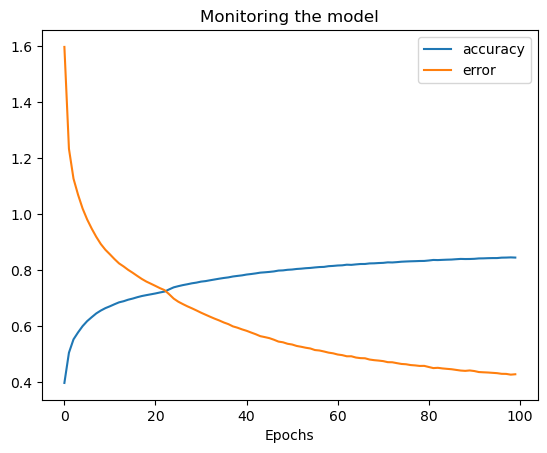

In [66]:
# plt.plot(errors);
plt.plot(acc, label='accuracy');
plt.plot(errors, label='error');
plt.xlabel('Epochs')
plt.title('Monitoring the model')
plt.legend();

<a id='eval'></a>
### Testing random graphs

In [95]:
idx = random.randint(0, len(Graphs_pyTorch))
G = Graphs_pyTorch[idx].to(device)
logits = model(G)
predicts = torch.argmax(logits, 1)

print(f'The real values: {G.roomType_embd}')
print(f'Predicted values: {predicts}')

The real values: tensor([0, 1, 2, 3, 3, 1, 4, 4], device='cuda:0')
Predicted values: tensor([0, 1, 2, 3, 3, 1, 4, 4], device='cuda:0')
